Note: This is a reference notebook just for illustrating results on a single image.

# Import Libraries

In [1]:
import cv2 as cv
import math
import argparse
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pytesseract
from pytesseract import Output
import re, string, copy, os, glob

In [2]:
#Arugment dictionary for default args 
args = {"input":"../test/all_images/img_0010.jpg", 
        "model":"../test/east_text_detection.pb", 
        "thr":0.8, 
        "nms": 0.4, 
        "width_std":640, 
        "height_std":800,
        "width_1":640,
        "height_1": 640,
        "padding":0.1,
        "tesseract_conf": 40}

In [3]:
#image to input
frame = cv.imread(args["input"])
orig = frame.copy()

# Text Detection - EAST

## Pre-process and Forward Pass into EAST

In [4]:
# Read arguments
confThreshold = args["thr"]
nmsThreshold = args["nms"]
model = args["model"]
confTesseract = args['tesseract_conf']

# Load the pre-trained EAST model
net = cv.dnn.readNet(model)

#Two outputs needed from the EAST model:
#1. Probability scores of whether an area contains text or not
#2. Coordinates of the bounding box when text is detected
outputNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]


In [5]:
#Get image height and width
og_height = frame.shape[0]
og_width = frame.shape[1]

if og_height == og_width:
    resized_width = args["width_1"]
    resized_height = args["height_1"]
else:
    resized_width =  args["width_std"]
    resized_height = args["height_std"]

rW = og_width / float(resized_width)
rH = og_height / float(resized_height)

In [6]:
#Resize original image to new dimensions
image = cv.resize(frame, (resized_width, resized_height))

#Create a 4D blob from image
blob = cv.dnn.blobFromImage(frame, 1.0, (resized_width, resized_height), (123.68, 116.78, 103.94), True, False)

#Forward pass the blob in EAST model
net.setInput(blob)
outs = net.forward(outputNames)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())

## Create Bounding Boxes

In [7]:
def decode(scores, geometry, scoreThresh):
    '''Returns bounding boxes and probabilit scores if above confidence threshold'''
    '''Code adapted from OpenCV Github -> Samples -> dnn'''
    '''Code from EAST Github is mostly in C++ implementation'''
    
    detections = []
    confidences = []

    #Checks for incorrect dimensions
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    
    height = scores.shape[2]
    width = scores.shape[3]
    
    #Loop over rows
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        
        #Loop over columns
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            #Multiply back to original dimnesions (EAST shrinks input by 4x)
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            #Calculate cos and sin of angle
            cosA = np.cos(angle)
            sinA = np.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            #Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            #Find points for bounding box 
            #This rotates bounding boxes for angled text as well
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / np.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [8]:
#Scores and geometry from model output
scores = outs[0]
geometry = outs[1]

[boxes, confidences] = decode(scores, geometry, confThreshold)


## Non-Maximum Suppression

In [9]:
#Apply non-maximum suppression and return indices of bounding boxes
indices = cv.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)

# Text Recognition - Tesseract

In [10]:
#Text Recognition

results = []

#Loop over bounding boxes to find coordinates/angle
for i in indices:
    center = boxes[i[0]][0]
    w, h = boxes[i[0]][1]
    angle = boxes[i[0]][2]
    
    #Center of bounding boxes    
    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)

    if w < h:
        w, h = h, w
        angle += 90.0


    rows, cols, _ = image.shape

    #Rotate bounding boxes that have angled text
    matrix       = cv.getRotationMatrix2D(center, angle, 1)
    rotated = cv.warpAffine(image, matrix, (cols, rows))
    
    #padding
    dX = int(w * args["padding"])
    dY = int(h * args["padding"])

    #Crop the rotated bounding box
    start_y = int((center_y - (h / 2)) - dY)
    end_y   = int((start_y + h) + (2 * dY))
    start_x = int((center_x - (w / 2)) - dX)
    end_x   = int((start_x + w) + (2 * dX))
    start_x = start_x if 0 <= start_x < cols else (0 if start_x < 0 else cols-1)
    end_x   = end_x if 0 <= end_x < cols else (0 if end_x < 0 else cols-1)
    start_y = start_y if 0 <= start_y < rows else (0 if start_y < 0 else rows-1)
    end_y   = end_y if 0 <= end_y < rows else (0 if end_y < 0 else rows-1)
    crop    = rotated[start_y:end_y, start_x:end_x]
    
    #Rescale very small bounding boxes to 32 height
    if h < 32:
        crop = cv.resize(crop, None, fx=32/h, fy=32/h, interpolation=cv.INTER_CUBIC)
    else:
        crop

    #Configuration setting to convert image to string
    #Chosen english and spanish
    configuration = ("-l eng+spa --oem 1 --psm 6")

    #Recognize the text from the bounding box image 
    text = pytesseract.image_to_data(crop, config=configuration, output_type='data.frame')
    selected_text = text.loc[(text['conf'] > confTesseract), ['conf','text']]
    selected_text = selected_text.values.tolist()
    
    if not selected_text:
        continue
    
    results.append(((start_x, start_y, end_x, end_y), selected_text))

In [11]:
#results = sorted(results, key=lambda x: x[0][1])

In [12]:
results

[((254, 558, 375, 583), [[95, 'Washed']]),
 ((475, 572, 556, 601), [[87.0, 2509.0]]),
 ((150, 591, 181, 606), [[96, 'friar']]),
 ((179, 590, 224, 605), [[53, '‘plum,']]),
 ((138, 522, 343, 553), [[76, '1'], [79, 'SAMBEWE']]),
 ((143, 559, 267, 584), [[96, 'Tanzania'], [95, '|']]),
 ((369, 242, 546, 290), [[96, 'EVEN']]),
 ((133, 246, 273, 297), [[96, 'NOT']]),
 ((265, 586, 338, 602), [[93, 'molasses']]),
 ((270, 264, 372, 283), [[96, 'ROASTERS']]),
 ((277, 252, 362, 267), [[95, 'COFFEE']])]

# Update in Image

['Washed', '25090', 'friar', '‘plum', '1', 'SAMBEWE', 'Tanzania', '', 'EVEN', 'NOT', 'molasses', 'ROASTERS', 'COFFEE']


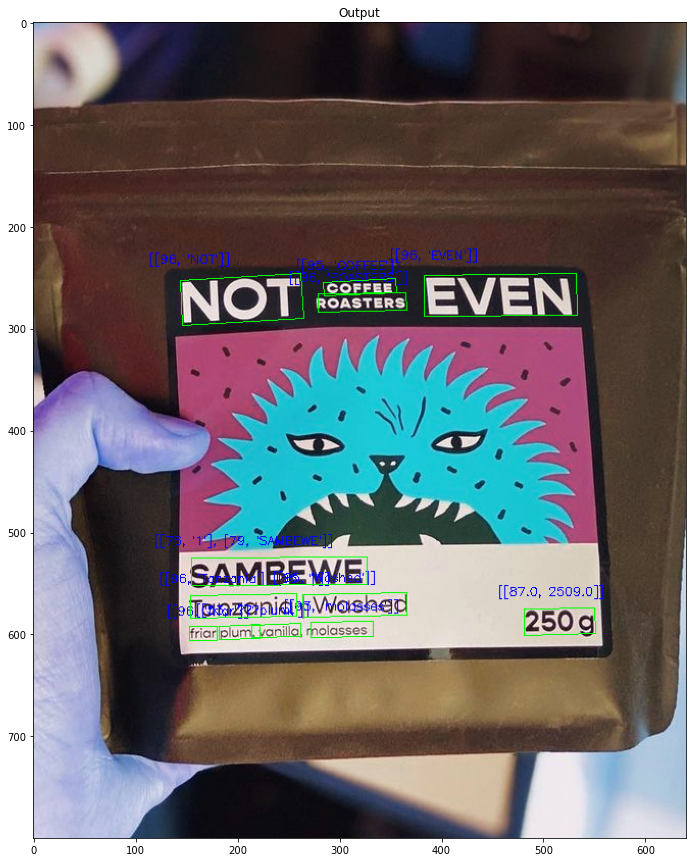

In [20]:
#Display the image with bounding box and recognized text
orig_image = image.copy()

words = []
#Display text
for ((start_x, start_y, end_x, end_y), text) in results:
      
    for each_word in text:
        if re.search(r'[:.,|]', str(each_word[1])):
            words.append(re.sub(r'[:.,|]','', str(each_word[1])))
        else:
            words.append(each_word[1])

    cv.putText(orig_image, str(text), (start_x - 20, start_y - 10),
        cv.FONT_HERSHEY_SIMPLEX, 0.4,(0, 0, 255), 1)

#Display bounding boxes
for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv.boxPoints(boxes[i[0]])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] #*= rW
        vertices[j][1] #*= rH
    for j in range(4):
        p1 = (int(vertices[j][0]), int(vertices[j][1]))
        p2 = (int(vertices[(j + 1) % 4][0]), int(vertices[(j + 1) % 4][1]))
        cv.line(orig_image, p1, p2, (0, 255, 0), 1);

    
print(words)
plt.figure(figsize = (15,15))
plt.imshow(orig_image)
plt.title('Output')
plt.show()

## Personal Reference

[[96, 'friar']]

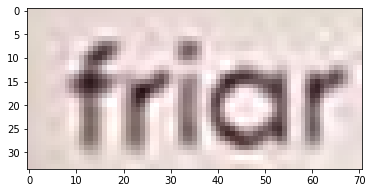

In [17]:
center = boxes[indices[2][0]][0] 
w, h = boxes[indices[2][0]][1]
angle = boxes[indices[2][0]][2]
    
#Center of bounding boxes    
center_X, center_Y = center
center_X = int(center_X )
center_Y = int(center_Y )

if w < h:
    w, h = h, w
    angle += 90.0


rows, cols, _ = image.shape

#Rotate bounding boxes that have angled text
M       = cv.getRotationMatrix2D(center, angle, 1)
rotated = cv.warpAffine(image, M, (cols, rows))

#padding
dX = int(w * args["padding"])
dY = int(h * args["padding"])

#Crop the rotated bounding box
start_y = int((center_Y - (h / 2)) - dY)
end_y   = int((start_y + h) + (2 * dY))
start_x = int((center_X - (w / 2)) - dX)
end_x   = int((start_x + w) + (2 * dX))
start_x = start_x if 0 <= start_x < cols else (0 if start_x < 0 else cols-1)
end_x   = end_x if 0 <= end_x < cols else (0 if end_x < 0 else cols-1)
start_y = start_y if 0 <= start_y < rows else (0 if start_y < 0 else rows-1)
end_y   = end_y if 0 <= end_y < rows else (0 if end_y < 0 else rows-1)


crop = rotated[start_y:end_y, start_x:end_x]

if h < 32:
    crop = cv.resize(crop, None, fx=32/h, fy=32/h, interpolation=cv.INTER_CUBIC)
else:
    crop
    
#crop1 = cv.resize(crop, None, fx=1, fy=1, interpolation=cv.INTER_AREA)
#crop1 = cv.resize(crop, None, fx=1, fy=1, interpolation=cv.INTER_CUBIC)

#crop1 = cv.GaussianBlur(crop1, (5, 5), 0)

#Configuration setting to convert image to string
#Chosen english and spanish
configuration = ("-l eng+spa --oem 1 --psm 6")

#Recognize the text from the bounding box image 
test = pytesseract.image_to_data(crop, config=configuration, output_type='data.frame')
plt.imshow(crop)
selected_test = test.loc[(test['conf'] > confTesseract), ['conf','text']]
final_test = selected_test.values.tolist()


if len(final_test) >= 2:
    final_test = selected_test.loc[selected_test['conf'].idxmax(),:]
    final_test = final_test.values.tolist()
else:
    final_test
final_test

## TBC Merge Bounding Boxes

In [18]:
# text_box = [bbox[0] for bbox in results]
# text = [bbox[1] for bbox in results]

# dist_limit = 10

# #Copy of the text and object arrays
# text_copied = copy.deepcopy(text)
# text_box_copied = copy.deepcopy(text_box)

# def merge_boxes(box1, box2):
#     return [min(box1[0], box2[0]), 
#          min(box1[1], box2[1]), 
#          max(box1[2], box2[2]),
#          max(box1[3], box2[3])]


# def calc_sim(box1, box2):
#     box1_xmin, box1_ymin, box1_xmax, box1_ymax  = box1
#     box2_xmin, box2_ymin, box2_xmax, box2_ymax = box2

#     x_dist = min(abs(box1_xmin-box2_xmin), abs(box1_xmin-box2_xmax), abs(box1_xmax-box2_xmin), abs(box1_xmax-box2_xmax))
#     y_dist = min(abs(box1_ymin-box2_ymin), abs(box1_ymin-box2_ymax), abs(box1_ymax-box2_ymin), abs(box1_ymax-box2_ymax))

#     dist = x_dist + y_dist
#     return dist

# #Function to merge text 
# def merge_algo(text, text_box):
#     for i, (text_1, text_box_1) in enumerate(zip(text, text_box)):
#         for j, (text_2, text_box_2) in enumerate(zip(text, text_box)):
#             if j <= i:
#                 continue
#             # Create a new box if a distances is less than disctance limit defined 
#             if calc_sim(text_box_1, text_box_2) < dist_limit:
#             # Create a new box  
#                 new_box = merge_boxes(text_box_1, text_box_2)            
#              # Create a new text string 
#                 new_text = text_1 + ' ' + text_2

#                 text[i] = new_text
#                 #delete previous text 
#                 del text[j]
#                 text_box[i] = new_box
#                 #delete previous text boxes
#                 del text_box[j]
#                 #return a new boxes and new text string that are close
#                 return True, text, text_box

#     return False, text, text_box

# need_to_merge = True

# #Merge full text 
# while need_to_merge:
#     need_to_merge, text_copied, text_box_copied = merge_algo(text_copied, text_box_copied)

# results1 = list(zip(text_box_copied, text_copied))
# results1

In [19]:
# #Display the image with bounding box and recognized text
# orig_image = image.copy()

# words = []
# #Display text
# for ((start_x, start_y, end_x, end_y), text) in results1:
    
#     #Remove words that Tesseract read from two lines due to lack of spacing
#     if re.search(r'\n\w', text):
#         pass
    
#     #Split words that have punctuation
#     elif re.search(r'[:.,]', text):
#         text_split = re.split(r'[:.,]', text)
#         for split_word in text_split:
#             words.append(re.sub(r'[\n-\x0c]','',split_word).strip(string.punctuation))
#     else:
#         words.append(re.sub('[\n-\x0c]','',text))

#     text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
#     cv.putText(orig_image, text, (start_x - 20, start_y - 10),
#         cv.FONT_HERSHEY_SIMPLEX, 0.4,(0, 0, 255), 1)

# #Display bounding boxes
# for i in indices:
#     # get 4 corners of the rotated rect
#     vertices = cv.boxPoints(boxes[i[0]])
#     # scale the bounding box coordinates based on the respective ratios
#     for j in range(4):
#         vertices[j][0] #*= rW
#         vertices[j][1] #*= rH
#     for j in range(4):
#         p1 = (int(vertices[j][0]), int(vertices[j][1]))
#         p2 = (int(vertices[(j + 1) % 4][0]), int(vertices[(j + 1) % 4][1]))
#         cv.line(orig_image, p1, p2, (0, 255, 0), 1);

    
# print(words)
# plt.figure(figsize = (10,10))
# plt.imshow(orig_image)
# plt.title('Output')
# plt.show()